# Benchmark 2.0 

- This time, we are using a new database : SLKB, which has higher-quality, uniform data
- We are integrating the wilcox displacement estimate into the labeling of our positive results (which should have been done already)
- We will use no negative samples, instead relying on positive vs unlabeled samples
- Positive samples will be benchmarked against interactions found in n different cell lines
- SLKB uses different scoring systems with small overlap. 
  
- We will evaluate the overlap with each scoring system separately, at different thresholds : draw a heatmap table with one column per scoring system, and one row per score threshold, where each square is colored corresponding to the precision of the model.
- This heatmap can be redrawn for different p-value thresholds and numbers of cell lines

In [20]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

from collections import Counter

In [62]:
def filter_database(num_cell_lines, negative_dataset, positive_negative_ratio=None, include_non_sli_data=True):
    # This cell allows you to download the necessary SLKB files
    # Google drive links come from slkb.osubmi.org
    global pd, np, os, requests, random

    file_urls = {
        "inputs/SLKB_predictions.xlsx": "https://slkb.osubmi.org/session/09c5c4738990db9810156682c87de6b8/download/download_data-predSL?w="
    }

    os.makedirs("inputs", exist_ok=True)

    for filepath, file_url in file_urls.items():
        if not os.path.exists(filepath):
            print(f"Downloading {filepath}...")
            response = requests.get(file_url)
            response.raise_for_status() 
            with open(filepath, "wb") as f:
                f.write(response.content)

    # 1. Filtering the benchmark dataset

    # This table, from SLKB, shows which SL pairs scored within the top 10% of 5 different scoring systems, among 22 different cell lines.
    # Downloaded on 04/04/2025 from the provided link

    slkb_predictions = pd.read_excel("inputs/SLKB_predictions.xlsx", sheet_name=None)
    
    # The "strict" version of the negative samples takes in the 10% worst scoring pairs 
    # The "stricter" version uses the 5% worst scoring pairs instead
    if negative_dataset == "strict":
        slkb_predictions_nonsli = pd.read_csv("inputs/slkb_negative_samples_strict.csv")
    elif negative_dataset == "stricter":
        slkb_predictions_nonsli = pd.read_csv("inputs/slkb_negative_samples_stricter.csv")
    elif negative_dataset == "1to1":
        slkb_predictions_nonsli = pd.read_csv("inputs/slkb_negative_samples_1to1.csv")
    else:
        raise ValueError("Dataset not in ['strict', 'stricter', '1to1']")

    # This is the list of genes that were included in the study
    reactome_genes = pd.read_excel("inputs/reactome genes list (to include).xlsx")
    ko_genes_list = reactome_genes["gene_name"].tolist()

    print("> Filtering benchmark dataset for data quality: ")

    # Here, we also have to concatenate the different sheets 
    # Each of them corresponds to a different cell line, which is integrated in a new "cell line" column
    slkb_predictions = pd.concat(
    [df.assign(cell_line=name) for name, df in slkb_predictions.items()],
    ignore_index=True
    )

    # We separate the "gene_pair" column into two separate columns, to match the format of our first table
    slkb_predictions[["gene1", "gene2"]] = slkb_predictions["gene_pair"].str.split('|', expand=True)
    slkb_predictions.drop(columns="gene_pair", inplace=True)

    # According to the SLKB paper, genes are considered "SLi" if they are in the top 10% of at least 3 different scoring systems, so we filter the dataframe accordingly
    slkb_predictions_sli = slkb_predictions[slkb_predictions["total_count"] >= 3]

    # Group by gene pairs and aggregate cell lines and scoring metrics
    slkb_predictions_sli = slkb_predictions_sli.groupby(['gene1', 'gene2']).agg({
        'cell_line': lambda x: ';'.join(sorted(set(x))),
    }).reset_index()

    print("Number of unique SLi pairs: ", slkb_predictions_sli.shape[0])

    # We now need to filter the SLi pairs to only include those that are also present in the reactome database
    slkb_predictions_sli = slkb_predictions_sli[
        slkb_predictions_sli['gene1'].isin(ko_genes_list) & slkb_predictions_sli['gene2'].isin(ko_genes_list)
    ]
    print("number of SLis after removing non-reactome genes: ", slkb_predictions_sli.shape[0])

    # Create a column for the number of cell lines
    slkb_predictions_sli['n_cell_lines'] = slkb_predictions_sli['cell_line'].str.split(';').apply(len)

    # We then filter the SLi pairs to only include those that have been found in at least {num_cell_lines} different cell lines
    slkb_predictions_sli = slkb_predictions_sli[
        slkb_predictions_sli['n_cell_lines'] >= num_cell_lines
    ]

    slkb_predictions_nonsli['n_cell_lines'] = 'NA'

    n_initial_slis = slkb_predictions_sli.shape[0]

    print(f"number of SLis after removing interactions found in less than {num_cell_lines} cell lines: ", n_initial_slis)

    # Creating a new column to indicate that these are SLi pairs, filled with 1s
    slkb_predictions_sli["sli"] = 1
    slkb_predictions_nonsli["sli"] = 0

    n_initial_nonslis = slkb_predictions_nonsli.shape[0]

    print("number of non-SLis: ", n_initial_nonslis)

    # 2. Filtering the model dataset

    # This csv file is the output of the model we want to benchmark
    # It contains our model's predictions, generated by an R script
    model_predictions = pd.read_csv("inputs/24mai_Output_all_rds.csv")

    print("> Filtering model dataset to only keep pairs in the benchmark dataset ")

    # We first extract the list of "mutant" genes included in our model, by getting the names of the tabs in the excel file, this will be used later
    mutant_genes = model_predictions.keys()
    mutant_genes_list = list(mutant_genes)

    # Then, we extract a list of "ko" genes, which are simply all of the genes that each mutant (such as AKT1) was tested against. 
    # Of course, this also has to include AKT1 itself.
    ko_genes_list = model_predictions[model_predictions['mutant'] == 'AKT1']['gene'].tolist()
    if 'AKT1' not in ko_genes_list:
        ko_genes_list.append('AKT1')

    print("Length of ko genes list:", len(ko_genes_list))
    print("Length of mutant genes list:", len(mutant_genes_list))
    print("Rows in model predictions dataframe: ", model_predictions.shape[0])
    model_predictions.head()

    # Now, we turn our gene pairs into sets so that we can efficiently compare them
    # Create sets of gene pairs from the benchmark for efficient lookup
    # Filter once

    # Create sets of gene pairs from the benchmark for efficient lookup
    benchmark_sli_set = set(
        slkb_predictions_sli.apply(lambda row:tuple(sorted((row['gene1'], row['gene2']))), axis=1)
    )

    if include_non_sli_data:
        benchmark_nonsli_set = set(
            slkb_predictions_nonsli.apply(lambda row:tuple(sorted((row['gene1'], row['gene2']))), axis=1)
        )

    # Then, we filter the huge model predictions dataframe to keep only the rows that are in the benchmark dataset
    filtered_rows = []
    model_pairs_set = set()

    # Precompute pair tuples for all rows
    model_predictions['sorted_pair'] = model_predictions.apply(
        lambda row: tuple(sorted((row['mutant'], row['gene']))), axis=1
    )

    # Mask for rows in either benchmark set
    mask_sli = model_predictions['sorted_pair'].isin(benchmark_sli_set)
    mask_nonsli = (
        include_non_sli_data and model_predictions['sorted_pair'].isin(benchmark_nonsli_set)
    )

    # Combine masks and filter
    if include_non_sli_data:
        mask = mask_sli | mask_nonsli
    else:
        mask = mask_sli

    model_predictions_filtered = model_predictions[mask].copy()

    # Add SLi column: 1 if in benchmark_sli_set, 0 if in benchmark_nonsli_set
    model_predictions_filtered['SLi'] = 0  # Initialize with 0
    model_predictions_filtered.loc[
        model_predictions_filtered['sorted_pair'].isin(benchmark_sli_set), 'SLi'
    ] = 1

    # Add n_cell_lines information by merging with benchmark data
    # First, create a mapping from gene pairs to n_cell_lines
    pair_to_n_cell_lines = {}

    # Add positive pairs (from slkb_predictions_sli)
    for _, row in slkb_predictions_sli.iterrows():
        pair = tuple(sorted((row['gene1'], row['gene2'])))
        pair_to_n_cell_lines[pair] = row['n_cell_lines']

    # Add negative pairs (these will have 'NA' as specified earlier)
    for _, row in slkb_predictions_nonsli.iterrows():
        pair = tuple(sorted((row['gene1'], row['gene2'])))
        pair_to_n_cell_lines[pair] = 'NA'

    # Map n_cell_lines to model_predictions_filtered
    model_predictions_filtered['n_cell_lines'] = model_predictions_filtered['sorted_pair'].map(pair_to_n_cell_lines)

    model_pairs_set = set(model_predictions_filtered['sorted_pair'])

    print("Number of model predictions that are present in either benchmark dataset:", len(model_pairs_set))

    # Note that there are a number of duplicate rows with different values. We keep the lowest p-adj for each pair only 
    model_predictions_filtered['sorted_pair'] = model_predictions_filtered.apply(lambda row: tuple(sorted((row['mutant'], row['gene']))), axis=1)
    idx = model_predictions_filtered.groupby('sorted_pair')['p_adj'].idxmin()
    model_predictions_filtered = model_predictions_filtered.loc[idx]
    model_predictions_filtered = model_predictions_filtered.drop_duplicates(subset="sorted_pair")
    model_predictions_filtered = model_predictions_filtered.drop(columns=['sorted_pair'])

    print("Number of model predictions after dropping duplicate gene pairs :", model_predictions_filtered.shape[0])

    # Finally, we remove pairs in our benchmark dataset that are not represented in our model's dataset, if there are any
    benchmark_sli_set_filtered = set()

    for pair in benchmark_sli_set:
        if pair in model_pairs_set:
            benchmark_sli_set_filtered.add(pair)
    # Replace the original set with the filtered one after the loop is complete
    benchmark_sli_set = benchmark_sli_set_filtered
    print(f"Removed benchmark SLis that were not included in the model's dataset: {n_initial_slis - len(benchmark_sli_set)} ")

    # If necessary, we generate a non-sli pair set of equal length
    if include_non_sli_data:
        benchmark_nonsli_set_filtered = set()
        missing_nonsli_pairs = set()
        for pair in benchmark_nonsli_set:
            if pair in model_pairs_set:
                benchmark_nonsli_set_filtered.add(pair)
            else:
                missing_nonsli_pairs.add(pair)

        benchmark_nonsli_set = benchmark_nonsli_set_filtered
        print(f"Removed benchmark nonSLis that were not included in the model's dataset: {n_initial_nonslis - len(benchmark_nonsli_set)} ")

        if positive_negative_ratio:
            # Calculate desired number of non-SLI samples based on positive-negative ratio
            n = int(len(benchmark_sli_set) * positive_negative_ratio)
        
            # Sample randomly if we have more non-SLI pairs than needed
            if len(benchmark_nonsli_set) > n:
                print(f"Sampling randomly from the non-SLIs to maintain the 1:{positive_negative_ratio} Positive/Negative ratio")
                
                # Convert to list for sampling
                benchmark_nonsli_list = list(benchmark_nonsli_set)
                
                # Sample n pairs randomly
                import random
                random.seed(42)  # For reproducibility
                sampled_nonsli_list = random.sample(benchmark_nonsli_list, n)
                
                # Replace the original set with the sampled subset
                benchmark_nonsli_set = set(sampled_nonsli_list)
                
                print(f"Sampled {len(benchmark_nonsli_set)} non-SLI pairs (target was {n})")

        if len(benchmark_nonsli_set) > 0:
            print(f"{len(missing_nonsli_pairs)} non-SLI pairs were not found in the model dataset.")
            
            # First, make sure each pair is sorted alphabetically (though as tuples they likely already are)
            sorted_pairs = [tuple(sorted(pair)) for pair in missing_nonsli_pairs]

            # Sort the entire list of pairs
            sorted_pairs.sort()

            # Extract just the first gene from each pair and ensure uniqueness
            first_genes = sorted(set([pair[0] for pair in sorted_pairs]))

            # Save the unique first genes to a CSV file
            import pandas as pd
            pd.Series(first_genes).to_csv("missing_nonsli_first_genes.csv", index=False, header=False)

        return benchmark_sli_set, benchmark_nonsli_set, model_predictions_filtered

In [55]:
num_cell_lines=3
negative_dataset="strict"
positive_negative_ratio=None

benchmark_sli_set, benchmark_nonsli_set, model_predictions_filtered = filter_database(num_cell_lines, negative_dataset, positive_negative_ratio)

KeyboardInterrupt: 

### Positive classification conditions for our model : 
- Wilcox displacement estimate over 0.15
- p-value under 1e-3 or 1e-4 (to be adjusted)
- for the gene pairs that were tested multiple times, one positive classification is sufficient

### SLKB conditions for positive classification
- It depends on the scoring system
- It depends on the number of cell lines in which it's been identified (2+)

In [24]:
# Create a set of unique pairs from the benchmark database, based on a p_adj threshold
def get_hashed_pair_scores():
    """Preprocess the data once for all thresholds"""
    # Create a mapping from gene pairs to their p_adj values
    pair_to_scores = {}
    
    for _, row in model_predictions_filtered.iterrows():
        gene = row['gene']
        mutant = row['mutant']
        model_pair_sorted = tuple(sorted((gene, mutant)))
        
        # Only consider pairs in our benchmark sets
        if model_pair_sorted in benchmark_sli_set or model_pair_sorted in benchmark_nonsli_set:
            # Take the lowest p_adj if multiple entries exist
            if model_pair_sorted not in pair_to_scores or row['p_adj'] < pair_to_scores[model_pair_sorted]['p_adj']:
                pair_to_scores[model_pair_sorted] = {}
                pair_to_scores[model_pair_sorted]['p_adj'] = row['p_adj']
                # Add the estimate for the corresponding value
                pair_to_scores[model_pair_sorted]['estimate'] = row['estimate']
    
    return pair_to_scores

pair_to_scores = get_hashed_pair_scores()

In [25]:
def get_confusion_sets(p_adj_threshold, estimate_threshold, pair_to_scores, print_tables=False, include_non_sli_data=True):
    # Generate model_sli_set and model_nonsli_set for this threshold
    model_sli_set = set()
    model_nonsli_set = set()
    for pair, scores in pair_to_scores.items():
        if scores['p_adj'] <= p_adj_threshold and (
            estimate_threshold is None or scores['estimate'] <= estimate_threshold
        ):
            model_sli_set.add(pair)
        else:
            model_nonsli_set.add(pair)
    
    # Calculate confusion matrix values
    confusion = {
        "TP": model_sli_set.intersection(benchmark_sli_set),
        "FP": model_sli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "TN": model_nonsli_set.intersection(benchmark_nonsli_set) if include_non_sli_data else set(),
        "FN": model_nonsli_set.intersection(benchmark_sli_set)
    }
    
    if print_tables:
        print(f"True Positives (TP): {len(confusion['TP'])}")
        for item in confusion["TP"]:
            print(f"{item}: p_adj={pair_to_scores[item]['p_adj']}, estimate={pair_to_scores[item]['estimate']}")
            # This condition should be True for all TPs
            print(f"  SLI condition met: {pair_to_scores[item]['p_adj'] <= p_adj_threshold and pair_to_scores[item]['estimate'] <= estimate_threshold}")
        print(f"False Positives (FP): {len(confusion['FP'])}")
        print(f"True Negatives (TN): {len(confusion['TN'])}")
        print(f"False Negatives (FN): {len(confusion['FN'])}")
        
    return confusion
    

def get_recall(confusion):
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    recall = TP / (TP + FN) if (TP + FN) > 0 else None
    return recall


def get_precision(confusion):
    TP = len(confusion["TP"])
    FP = len(confusion["FP"])
    precision = TP / (TP + FP) if (TP + FP) > 0 else None
    return precision

# This metric is similar to the F1 score but for Positive/Unlabeled (PU) Data 
# the positive_prediction_ratio corresponds to Pr(ŷ = 1), so the proportion of total model predictions that are positive
def get_pu_metric(confusion):
    recall = get_recall(confusion)
    positive_prediction_ratio = len(confusion["TP"]) / (len(confusion["TP"]) + len(confusion["FP"]))
    pu_metric = (recall * recall) / positive_prediction_ratio if positive_prediction_ratio > 0 else None
    return pu_metric

def get_tp_rate(confusion):
    TP = len(confusion["TP"])
    FN = len(confusion["FN"])
    
    tp_rate = TP / (TP + FN) if (TP + FN) > 0 else None
    return tp_rate

def get_fp_rate(confusion):
    FP = len(confusion["FP"])
    TN = len(confusion["TN"])
    
    fp_rate = FP / (FP + TN) if (FP + TN) > 0 else None
    return fp_rate

Estimate threshold None: Area Under PR Curve (AUC-PR): 0.0606


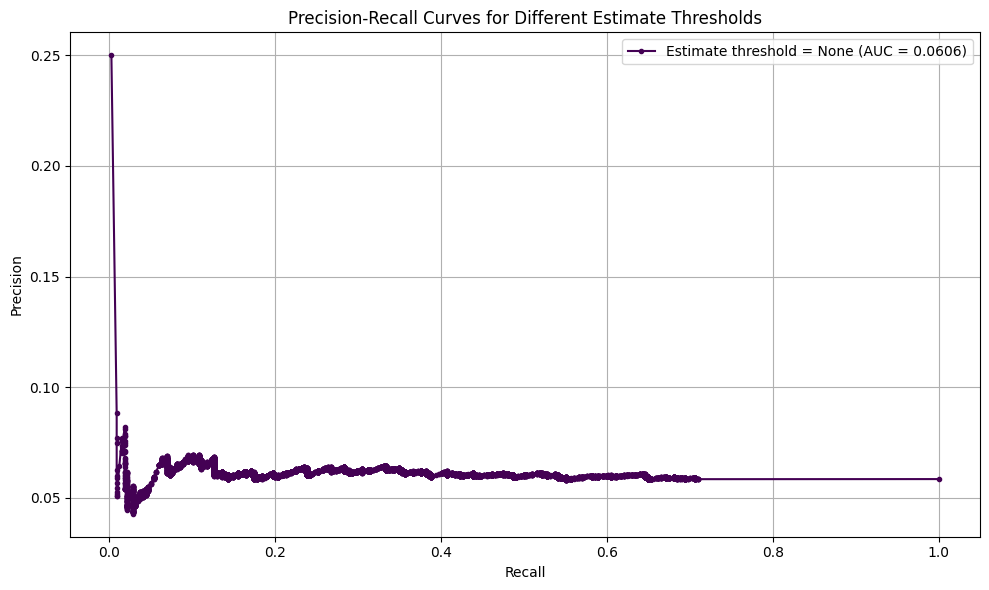

In [ ]:
# Define the p-value thresholds
p_adj_thresholds = np.linspace(0.0000000001, 1, 10000)
estimate_thresholds = [None]

def get_curve(p_adj_thresholds, estimate_thresholds, type):
    plt.figure(figsize=(10, 6))
    
    # Set up a color map for different curves
    colors = plt.cm.viridis(np.linspace(0, 1, len(estimate_thresholds)))
    
    for idx, e_thresh in enumerate(estimate_thresholds):
        Yaxis = []
        Xaxis = []
        
        for p_thresh in p_adj_thresholds:
            confusion = get_confusion_sets(p_thresh, e_thresh, pair_to_scores)
            if type == "PR":
                y = get_precision(confusion)
                x = get_recall(confusion)
            elif type == "ROC":
                y = get_tp_rate(confusion)
                x = get_fp_rate(confusion)
            else:
                raise ValueError("Invalid type. Use 'PR' for Precision-Recall or 'ROC' for ROC curve.")
            
            if x is not None and y is not None:
                Yaxis.append(y)
                Xaxis.append(x)
        
        # Calculate AUC if we have data points
        if len(Xaxis) > 0:
            # Sort the points by x-axis value
            sorted_indices = np.argsort(Xaxis)
            sorted_x = [Xaxis[i] for i in sorted_indices]
            sorted_y = [Yaxis[i] for i in sorted_indices]
            
            if type == "ROC":
                area = auc(sorted_x, sorted_y)
                print(f"Estimate threshold {e_thresh}: Area Under ROC Curve (AUC-ROC): {area:.4f}")
            elif type == "PR":
                area = auc(sorted_x, sorted_y)
                print(f"Estimate threshold {e_thresh}: Area Under PR Curve (AUC-PR): {area:.4f}")
        
        # Plot this curve with a unique color and label
        plt.plot(Xaxis, Yaxis, marker='o', markersize=3, color=colors[idx], 
                 label=f'Estimate threshold = {e_thresh} (AUC = {area:.4f})')
    
    # Add appropriate labels based on curve type
    if type == "PR":
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curves for Different Estimate Thresholds")
    elif type == "ROC":
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves for Different Estimate Thresholds")
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
# Define parameters
estimates = [None]
p_adjs = [0.0001, 0.0000001]

def get_results_table(estimates, p_adjs):
    # Print headers first - put estimate thresholds as column headers
    header = "metric"
    for estimate_threshold in estimates:
        header += f"\testimate={estimate_threshold}"
    print(header)

    # For each metric, create a row with values for different estimate thresholds
    metrics = ["p_adj", "TP", "FN", "TN", "FP", "Precision", "Recall", "TPR", "FPR"]

    for p_adj_threshold in p_adjs:
        # Start a section for this p_adj threshold
        print(f"\np_adj = {p_adj_threshold:.1e}")
        
        # Pre-calculate all results for this p_adj
        results = {}
        for estimate_threshold in estimates:
            confusion = get_confusion_sets(p_adj_threshold, estimate_threshold, pair_to_scores, print_tables=False)
            precision = get_precision(confusion)
            recall = get_recall(confusion)
            tp_rate = get_tp_rate(confusion)
            fp_rate = get_fp_rate(confusion)
            
            results[estimate_threshold] = {
                "TP": len(confusion["TP"]),
                "FN": len(confusion["FN"]),
                "TN": len(confusion["TN"]),
                "FP": len(confusion["FP"]),
                "Precision": f"{precision:.2%}" if precision is not None else "N/A",
                "Recall": f"{recall:.2%}" if recall is not None else "N/A",
                "TPR": f"{tp_rate:.2%}" if tp_rate is not None else "N/A",
                "FPR": f"{fp_rate:.2%}" if fp_rate is not None else "N/A"
            }
        
        # Print each metric as a row
        for metric in metrics[1:]:  # Skip p_adj since we already printed it as a section header
            row = f"{metric}"
            for estimate_threshold in estimates:
                row += f"\t{results[estimate_threshold][metric]}"
            print(row)

get_results_table(estimates, p_adjs)

metric	estimate=None

p_adj = 1.0e-04
TP	3
FN	311
TN	5019
FP	31
Precision	8.82%
Recall	0.96%
TPR	0.96%
FPR	0.61%

p_adj = 1.0e-07
TP	3
FN	311
TN	5044
FP	6
Precision	33.33%
Recall	0.96%
TPR	0.96%
FPR	0.12%


# Stricter database

In [63]:
positive_negative_ratio = None
num_cell_lines = 3
negative_dataset = "stricter"

In [64]:
benchmark_sli_set, benchmark_nonsli_set, model_predictions_filtered = filter_database(num_cell_lines, negative_dataset, positive_negative_ratio)

> Filtering benchmark dataset for data quality: 
Number of unique SLi pairs:  10455
number of SLis after removing non-reactome genes:  5464
number of SLis after removing interactions found in less than 3 cell lines:  314
number of non-SLis:  1785
> Filtering model dataset to only keep pairs in the benchmark dataset 
Length of ko genes list: 10053
Length of mutant genes list: 13
Rows in model predictions dataframe:  7448532
Number of model predictions that are present in either benchmark dataset: 2099
Number of model predictions after dropping duplicate gene pairs : 2099
Removed benchmark SLis that were not included in the model's dataset: 0 
Removed benchmark nonSLis that were not included in the model's dataset: 0 
0 non-SLI pairs were not found in the model dataset.


In [65]:
pair_to_scores = get_hashed_pair_scores()

estimates = [None]
p_adjs = [0.0001, 0.0000001]

get_results_table(estimates, p_adjs)

metric	estimate=None

p_adj = 1.0e-04
TP	3
FN	311
TN	1781
FP	4
Precision	42.86%
Recall	0.96%
TPR	0.96%
FPR	0.22%

p_adj = 1.0e-07
TP	3
FN	311
TN	1785
FP	0
Precision	100.00%
Recall	0.96%
TPR	0.96%
FPR	0.00%


In [ ]:
model_predictions_filtered = model_predictions_filtered.sort_values("p_adj")

model_predictions_filtered = model_predictions_filtered[["mutant", "gene","p_adj", "estimate", "SLi", "n_cell_lines"]]

model_predictions_filtered_sli=model_predictions_filtered[model_predictions_filtered["SLi"] == 1]

model_predictions_filtered_nonsli=model_predictions_filtered[model_predictions_filtered["SLi"] == 0].drop(columns="n_cell_lines")

In [82]:
import xlsxwriter

with pd.ExcelWriter('outputs/Benchmark Supplementary Table.xlsx', engine='xlsxwriter') as writer:
    model_predictions_filtered_sli.to_excel(writer, sheet_name='Benchmark SLi Pairs')
    model_predictions_filtered_nonsli.to_excel(writer, sheet_name='Benchmark NonSLi Pairs')

# 1:1 negative dataset

In [37]:
positive_negative_ratio = None
num_cell_lines = 3
negative_dataset = "1to1"

In [41]:
benchmark_sli_set, benchmark_nonsli_set, model_predictions_filtered = filter_database(num_cell_lines, negative_dataset, positive_negative_ratio)

> Filtering benchmark dataset for data quality: 
Number of unique SLi pairs:  10455
number of SLis after removing non-reactome genes:  5464
number of SLis after removing interactions found in less than 3 cell lines:  314
number of non-SLis:  314
> Filtering model dataset to only keep pairs in the benchmark dataset 
Length of ko genes list: 10053
Length of mutant genes list: 13
Rows in model predictions dataframe:  7448532
Number of model predictions that are present in either benchmark dataset: 628
Number of model predictions after dropping duplicate gene pairs : 628
Removed benchmark SLis that were not included in the model's dataset: 0 
Removed benchmark nonSLis that were not included in the model's dataset: 0 
0 non-SLI pairs were not found in the model dataset.


In [42]:
pair_to_scores = get_hashed_pair_scores()

estimates = [None]
p_adjs = [0.0001, 0.0000001]

get_results_table(estimates, p_adjs)

metric	estimate=None

p_adj = 1.0e-04
TP	3
FN	311
TN	314
FP	0
Precision	100.00%
Recall	0.96%
TPR	0.96%
FPR	0.00%

p_adj = 1.0e-07
TP	3
FN	311
TN	314
FP	0
Precision	100.00%
Recall	0.96%
TPR	0.96%
FPR	0.00%
